# ARモデル+tanhに従う時系列の次時刻予測を、準線形NNで行う。（最小二乗法）

In [1]:
import argparse
import os
path = os.getcwd()
path=path[:path.find('estimate-innovation')+20]
# No = (os.path.basename(__file__))[-4]
No = "0" # notebook用
# print('実験No.'+No)
import warnings
warnings.simplefilter('ignore')# 警告を非表示
import numpy as np
np.set_printoptions(precision=4, floatmode='fixed', suppress=True)
import matplotlib.pyplot as plt
from scipy import stats
import math
import sys
sys.path.append(path)
import random
import time
import statsmodels.api as sm
from scipy.stats import norm
import japanize_matplotlib
from scipy.stats import gaussian_kde

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
# 人工データを生成してくれる機械が置いてあるところ
import tsModel
# 学習用のニューラルネットが置いてあるところ
import models
# p-Wasserstein距離の関数
# import Wasserstein
path

'/home/lab/ryuichi/Documents/research/estimate-innovation/'

### GPUが使えるかどうかの確認

In [2]:
import checkGPU
cuda, device = checkGPU.checkGPU()

GPUが使えます。
GPUを使いますか？ （Yes：1, No：0）： 0


### ARモデルに従う時系列の作成

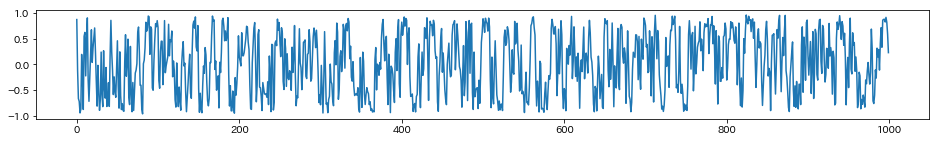

In [3]:
phi_a = [1.0, -0.5, 0.7, -0.4] ; phi_b = [0]
p = len(phi_a) ; q = len(phi_b)
dataSeed=5
N = 1000
data = tsModel.nonLinearARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='uniform', sigma=1/np.sqrt(3))
inno = tsModel.nonLinearARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='uniform', return_innovation=True, sigma=1/np.sqrt(3))
# 描画
plt.figure(figsize=(16,2)) ; plt.plot(data) ; plt.show()
# データをGPUかCPUに乗っける
data = torch.from_numpy(data).to(device)

### 推定に用いる$\hat p$を決定

In [4]:
hat_p = 4

### 学習曲線などの画像を保管するディレクトリと、NNのパラメータを保存するディレクトリを作成

In [5]:
os.makedirs("output-images/p{0}".format(hat_p), exist_ok=True)
os.makedirs("parameters/p{0}".format(hat_p), exist_ok=True)

### NNを学習する時のハイパラを決定する

In [6]:
# 学習する推定モデルの形状や学習方法なんかを決定します
# 学習時のハイパラの決定（入力を受け付ける）
parser = argparse.ArgumentParser()
# parser.add_argument("--generator_seed", type=int, default=0, help="generatorのパラメータの初期値のシード")
parser.add_argument("--predictor_seed", type=int, default=0, help="predictorのパラメータの初期値のシード")
parser.add_argument("--batch_size", type=int, default=1, help="batchの大きさ")
# parser.add_argument("--training_seed", type=int, default=0, help="訓練データを学習させる順番を決めるシード")
parser.add_argument("--n_epochs", type=int, default=1000, help="学習させる回数")

opt = parser.parse_args(args=[]) # .ipynbの場合はこちらを使用

### NNモデル（predictNet）を作成

In [7]:
torch.manual_seed(opt.predictor_seed)
predictor = models.semiLinearPredictNet(input_size=hat_p+1)
predictor = predictor.to(device)

In [8]:
# input_tensor = torch.rand([32, 5]).to(device)
# predictor(input_tensor).shape

### train と　validation　に分ける

In [9]:
trainData = data[:N//10*9]
valData = data[N//10*9:]

### データローダの作成

In [10]:
import my_preprocess
train_dataset = my_preprocess.DataSet(tsData=trainData, hat_p=hat_p, device=device)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=opt.batch_size, shuffle=True, drop_last=True)
val_dataset = my_preprocess.DataSet(tsData=valData, hat_p=hat_p, device=device)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, drop_last=True)

### 最適化手法の設定

In [11]:
optimizer_F = torch.optim.Adam(params=predictor.parameters(), lr=0.0001 )

### Lossの設計

In [12]:
mseLoss = nn.MSELoss()
mseLoss = mseLoss.to(device)

### 学習の間に保管したい値を格納する変数（lossの値など）

In [13]:
train_lossList_F = []
val_lossList_F = []

In [14]:
start = time.time()
minLoss = np.inf
paramPath = path+"kurtosis_loss/parameters/p{0}/pre_semiLinearPredictor.pth".format(hat_p)
for epoch in range(opt.n_epochs):
    train_epoch_loss = 0
#     optimizer_F.zero_grad()# 勾配情報を削除
    for idx, (X, Y) in enumerate(train_dataloader):
        input_tensor = torch.cat([torch.randn([opt.batch_size,1]), X], axis=1).to(device)# ランダムな次元を追加
        optimizer_F.zero_grad()# 勾配情報を削除
#         input_tensor = X.to(device)
        output_tensor = predictor(input_tensor)
        true_tensor = Y.to(device)
        loss_F = mseLoss(output_tensor, true_tensor)
        
#         optimizer_F.zero_grad()# 勾配情報を削除
        loss_F.backward()# 勾配をとる
        optimizer_F.step()# 勾配情報と最適化手法を元にparameterを更新
        train_epoch_loss += loss_F.item() # batchごとのlossを
    
    train_lossList_F.append(train_epoch_loss/(idx+1))
    
    val_epoch_loss = 0
    for idx, (X, Y) in enumerate(val_dataloader):
        input_tensor = torch.cat([torch.zeros([1,1]), X], axis=1).to(device)# ランダムな次元を追加
#         input_tensor = X.to(device)
        output_tensor = predictor(input_tensor)
        true_tensor = Y.to(device)
        val_loss_F = mseLoss(output_tensor, true_tensor)
        val_epoch_loss += val_loss_F.item()
    val_lossList_F.append(val_epoch_loss/(idx+1))
    
    if minLoss>val_lossList_F[-1]:
        minLoss = val_lossList_F[-1]
        torch.save(predictor.state_dict(), paramPath)

    if epoch%100==100-1:
        print("epoch：{0}/{1}   train_loss_F：{2: .4g}  val_loss_F:{3: .4g}   経過時間：{4: .1f}秒".format(epoch+1, opt.n_epochs, train_lossList_F[-1], val_lossList_F[-1], time.time()-start))
        

epoch：100/1000   train_loss_F： 0.1764  val_loss_F: 0.1763   経過時間： 51.9秒
epoch：200/1000   train_loss_F： 0.1766  val_loss_F: 0.1767   経過時間： 101.2秒
epoch：300/1000   train_loss_F： 0.1767  val_loss_F: 0.1767   経過時間： 150.7秒
epoch：400/1000   train_loss_F： 0.1765  val_loss_F: 0.1767   経過時間： 201.1秒
epoch：500/1000   train_loss_F： 0.1765  val_loss_F: 0.1767   経過時間： 252.8秒
epoch：600/1000   train_loss_F： 0.1768  val_loss_F: 0.1766   経過時間： 303.3秒
epoch：700/1000   train_loss_F： 0.1768  val_loss_F: 0.1767   経過時間： 353.9秒
epoch：800/1000   train_loss_F： 0.1765  val_loss_F: 0.1767   経過時間： 404.4秒
epoch：900/1000   train_loss_F： 0.1767  val_loss_F: 0.1767   経過時間： 454.6秒
epoch：1000/1000   train_loss_F： 0.1766  val_loss_F: 0.1768   経過時間： 505.1秒


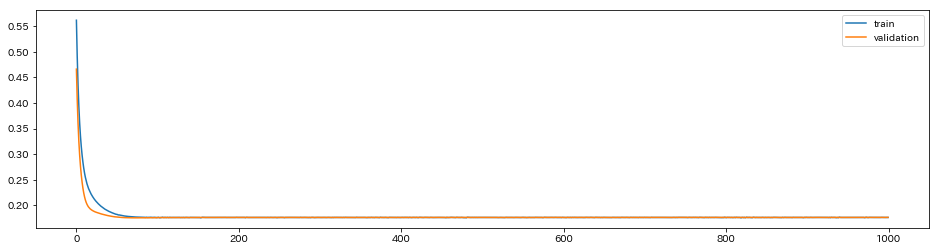

In [15]:
plt.figure(figsize=(16,4))
plt.plot(train_lossList_F, label="train")
plt.plot(val_lossList_F, label="validation")
plt.legend()

In [16]:
predictor.state_dict()

OrderedDict([('scale', tensor([1.3340])),
             ('fc1.weight',
              tensor([[ 4.6332e-04, -2.3505e-01,  4.1263e-01, -2.9162e-01,  6.1302e-01]]))])

In [17]:
phi_a

[1.0, -0.5, 0.7, -0.4]